# Analyzing Embeddings from the Pipeline

This notebook demonstrates how to load the HDF5 embeddings and metadata, and perform basic exploratory analysis.

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["figure.dpi"] = 100

## 1. Load Embeddings and Metadata

In [3]:
# Path to your HDF5 file
h5_path = r"K:\499-ProjectData\2025\P25-0048_Thyroid_Recurrence\06-UNI-adaptation\embeddings\test_thyroid_embeddings.h5"

print("Loading embeddings...")
with h5py.File(h5_path, "r") as f:
    print(f.keys())
    # Load embeddings
    embeddings = f["embeddings"][:]
    sample_codes = f["sample_codes"][:].astype(str)
    
    # Load all metadata into a DataFrame
    metadata = pd.DataFrame({
        "sample_code": sample_codes,
        "patch_index": f["metadata/patch_index"][:],
        "position_d": f["metadata/position_d"][:],
        "position_h": f["metadata/position_h"][:],
        "position_w": f["metadata/position_w"][:],
        "coord_d_norm": f["metadata/coord_d_normalized"][:],
        "coord_h_norm": f["metadata/coord_h_normalized"][:],
        "coord_w_norm": f["metadata/coord_w_normalized"][:],
        "tissue_pct": f["metadata/tissue_percentage"][:],
        "has_invasion": f["metadata/has_invasion"][:],
        "invasion_type": f["metadata/invasion_type"][:],
        "invasion_pct": f["metadata/invasion_percentage"][:],
    })
    
    print(f"\nLoaded {len(embeddings):,} embeddings")
    print(f"Embedding dimension: {embeddings.shape[1]}")
    print(f"Unique samples: {metadata['sample_code'].nunique()}")

Loading embeddings...
<KeysViewHDF5 ['embeddings', 'metadata', 'sample_codes']>

Loaded 2,131,779 embeddings
Embedding dimension: 1536
Unique samples: 132


## 2. Data Summary

In [4]:
print("=" * 80)
print("Dataset Summary")
print("=" * 80)

# Per-sample counts
sample_counts = metadata["sample_code"].value_counts()
print(f"\nPatches per sample:")
print(sample_counts.head(10))
print(f"\nStats: min={sample_counts.min()}, max={sample_counts.max()}, mean={sample_counts.mean():.1f}")

# Tissue distribution
print(f"\nTissue content:")
print(f"  Mean: {metadata['tissue_pct'].mean():.1f}%")
print(f"  Median: {metadata['tissue_pct'].median():.1f}%")
print(f"  Min: {metadata['tissue_pct'].min():.1f}%")
print(f"  Max: {metadata['tissue_pct'].max():.1f}%")

# Invasion distribution
print(f"\nInvasion statistics:")
print(f"  Patches with invasion: {metadata['has_invasion'].sum():,} ({metadata['has_invasion'].mean()*100:.1f}%)")
print(f"\nInvasion types:")
print(metadata["invasion_type"].value_counts().sort_index())

Dataset Summary

Patches per sample:
sample_code
087_B22.47370G    51740
083_B22.47370C    48230
069_B20.27515E    47432
157_B20.9465B     44520
155_B20.36205B    42867
113_B20.21926B    40068
161_B22.40556G    34632
071_B20.27515N    34450
082_B22.47370B    33280
011_B06.13608K    28611
Name: count, dtype: int64

Stats: min=160, max=51740, mean=16149.8

Tissue content:
  Mean: 29.5%
  Median: 6.0%
  Min: 0.0%
  Max: 100.0%

Invasion statistics:
  Patches with invasion: 69,213 (3.2%)

Invasion types:
invasion_type
0    2062566
1      34770
2       8555
3      18300
4       7588
Name: count, dtype: int64


## 3. Visualization: Metadata Distributions

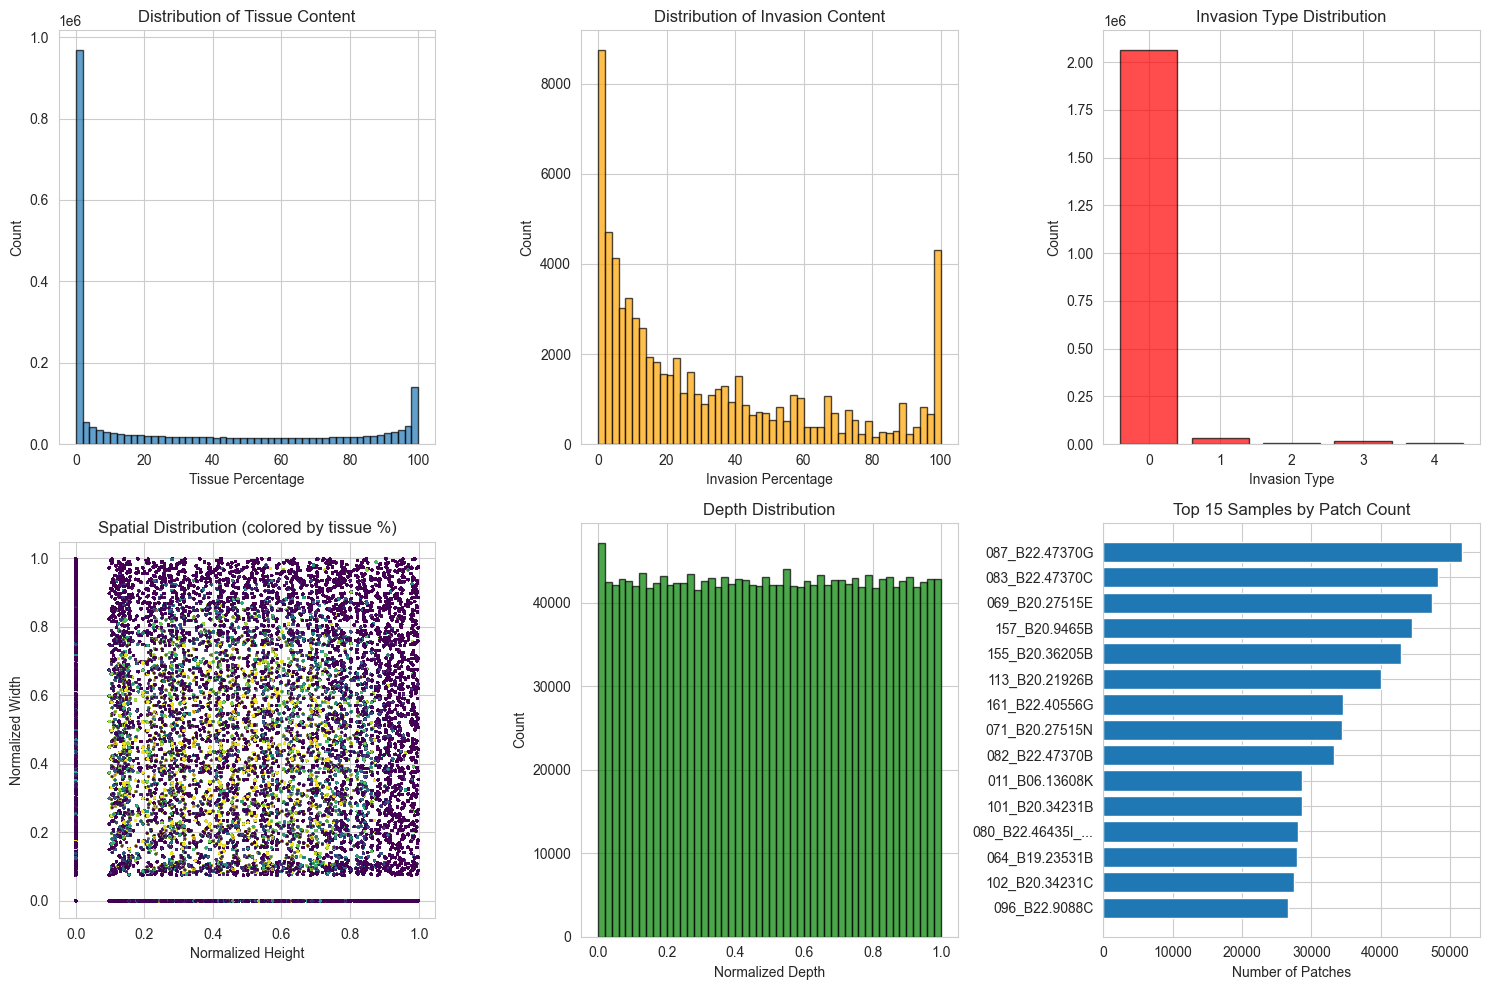

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Tissue percentage histogram
axes[0, 0].hist(metadata["tissue_pct"], bins=50, edgecolor="black", alpha=0.7)
axes[0, 0].set_xlabel("Tissue Percentage")
axes[0, 0].set_ylabel("Count")
axes[0, 0].set_title("Distribution of Tissue Content")

# Invasion percentage histogram (only patches with invasion)
invasion_patches = metadata[metadata["has_invasion"]]
if len(invasion_patches) > 0:
    axes[0, 1].hist(invasion_patches["invasion_pct"], bins=50, edgecolor="black", alpha=0.7, color="orange")
    axes[0, 1].set_xlabel("Invasion Percentage")
    axes[0, 1].set_ylabel("Count")
    axes[0, 1].set_title("Distribution of Invasion Content")
else:
    axes[0, 1].text(0.5, 0.5, "No invasion patches", ha="center", va="center")
    axes[0, 1].set_title("Distribution of Invasion Content")

# Invasion type distribution
invasion_counts = metadata["invasion_type"].value_counts().sort_index()
axes[0, 2].bar(invasion_counts.index, invasion_counts.values, edgecolor="black", alpha=0.7, color="red")
axes[0, 2].set_xlabel("Invasion Type")
axes[0, 2].set_ylabel("Count")
axes[0, 2].set_title("Invasion Type Distribution")
axes[0, 2].set_xticks(invasion_counts.index)

# Spatial distribution (normalized coordinates)
axes[1, 0].scatter(
    metadata["coord_h_norm"],
    metadata["coord_w_norm"],
    c=metadata["tissue_pct"],
    cmap="viridis",
    alpha=0.3,
    s=1,
)
axes[1, 0].set_xlabel("Normalized Height")
axes[1, 0].set_ylabel("Normalized Width")
axes[1, 0].set_title("Spatial Distribution (colored by tissue %)")
axes[1, 0].set_aspect("equal")

# Depth distribution
axes[1, 1].hist(metadata["coord_d_norm"], bins=50, edgecolor="black", alpha=0.7, color="green")
axes[1, 1].set_xlabel("Normalized Depth")
axes[1, 1].set_ylabel("Count")
axes[1, 1].set_title("Depth Distribution")

# Patches per sample
top_samples = sample_counts.head(15)
axes[1, 2].barh(range(len(top_samples)), top_samples.values)
axes[1, 2].set_yticks(range(len(top_samples)))
axes[1, 2].set_yticklabels([s[:15] + "..." if len(s) > 15 else s for s in top_samples.index])
axes[1, 2].set_xlabel("Number of Patches")
axes[1, 2].set_title("Top 15 Samples by Patch Count")
axes[1, 2].invert_yaxis()

plt.tight_layout()
plt.savefig("embedding_metadata_distributions.png", dpi=150, bbox_inches="tight")
plt.show()

## 4. Dimensionality Reduction: PCA

In [6]:
print("=" * 80)
print("Computing PCA...")
print("=" * 80)

# Subsample for faster computation (optional)
n_samples_pca = min(10000, len(embeddings))
indices = np.random.choice(len(embeddings), n_samples_pca, replace=False)

embeddings_subset = embeddings[indices]
metadata_subset = metadata.iloc[indices].copy()

# Compute PCA
pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(embeddings_subset)

print(f"Explained variance (first 10 components): {pca.explained_variance_ratio_[:10].sum():.1%}")

Computing PCA...
Explained variance (first 10 components): 55.0%


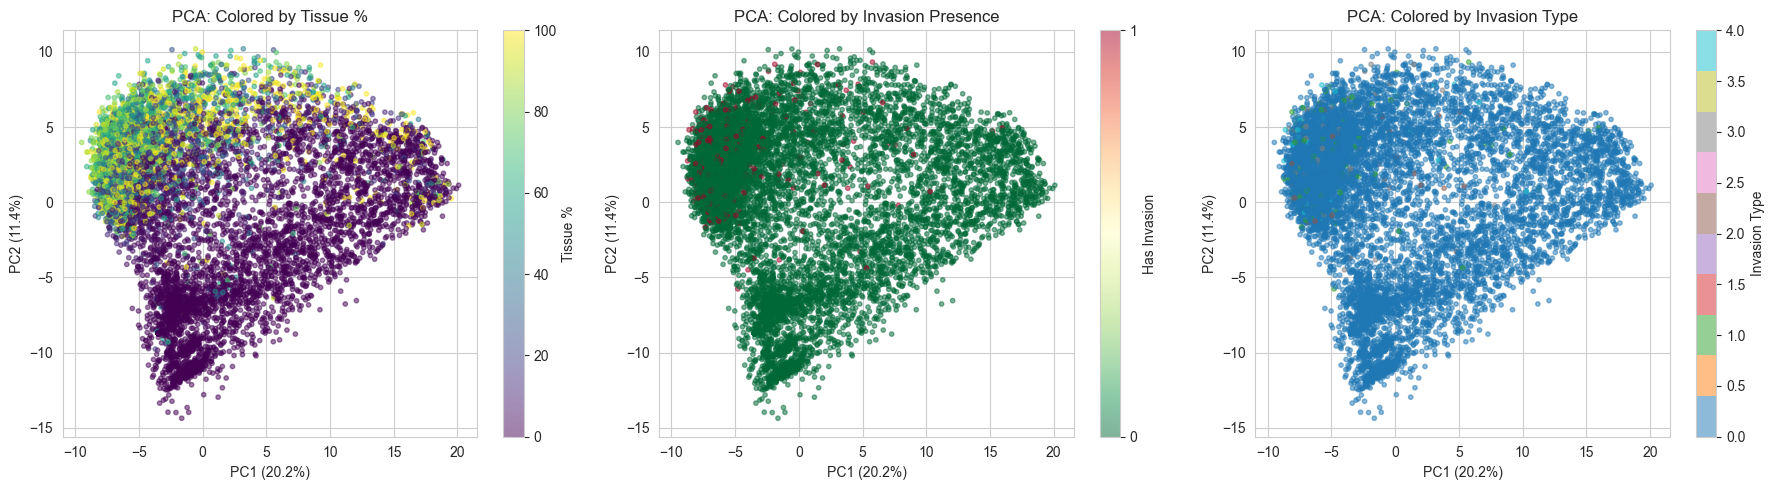

In [7]:
# Visualize PCA
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# PC1 vs PC2, colored by tissue percentage
scatter1 = axes[0].scatter(
    embeddings_pca[:, 0],
    embeddings_pca[:, 1],
    c=metadata_subset["tissue_pct"],
    cmap="viridis",
    alpha=0.5,
    s=10,
)
axes[0].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
axes[0].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
axes[0].set_title("PCA: Colored by Tissue %")
plt.colorbar(scatter1, ax=axes[0], label="Tissue %")

# PC1 vs PC2, colored by invasion presence
scatter2 = axes[1].scatter(
    embeddings_pca[:, 0],
    embeddings_pca[:, 1],
    c=metadata_subset["has_invasion"].astype(int),
    cmap="RdYlGn_r",
    alpha=0.5,
    s=10,
)
axes[1].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
axes[1].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
axes[1].set_title("PCA: Colored by Invasion Presence")
plt.colorbar(scatter2, ax=axes[1], label="Has Invasion", ticks=[0, 1])

# PC1 vs PC2, colored by invasion type
scatter3 = axes[2].scatter(
    embeddings_pca[:, 0],
    embeddings_pca[:, 1],
    c=metadata_subset["invasion_type"],
    cmap="tab10",
    alpha=0.5,
    s=10,
)
axes[2].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
axes[2].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
axes[2].set_title("PCA: Colored by Invasion Type")
plt.colorbar(scatter3, ax=axes[2], label="Invasion Type")

plt.tight_layout()
plt.savefig("embedding_pca.png", dpi=150, bbox_inches="tight")
plt.show()

## 5. Sample-Level Analysis

In [8]:
print("=" * 80)
print("Sample-Level Analysis")
print("=" * 80)

# Aggregate by sample
sample_stats = metadata.groupby("sample_code").agg({
    "tissue_pct": ["mean", "std", "min", "max"],
    "has_invasion": "mean",  # Fraction of patches with invasion
    "invasion_type": "max",  # Maximum invasion type seen
    "invasion_pct": "mean",
}).round(2)

sample_stats.columns = ["_".join(col).strip() for col in sample_stats.columns.values]
sample_stats["num_patches"] = metadata.groupby("sample_code").size()

print("\nSample statistics:")
print(sample_stats.head(10))

# Save to CSV
sample_stats.to_csv("sample_level_statistics.csv")
print(f"\nSaved sample statistics to: sample_level_statistics.csv")

Sample-Level Analysis

Sample statistics:
                tissue_pct_mean  tissue_pct_std  tissue_pct_min  \
sample_code                                                       
002_B05.20964B        22.129999       29.799999             0.0   
003_B05.23505H        19.950001       27.570000             0.0   
004_B05.7206D         34.730000       36.040001             0.0   
005_B05.10626C        24.910000       32.130001             0.0   
006_B05.10626G        26.330000       30.900000             0.0   
008_B05.14852B        23.549999       32.130001             0.0   
009_B05.14852C         9.990000       21.660000             0.0   
010_B05.14852A        16.280001       26.080000             0.0   
011_B06.13608K        30.860001       33.680000             0.0   
012_B06.13608O        18.120001       26.150000             0.0   

                tissue_pct_max  has_invasion_mean  invasion_type_max  \
sample_code                                                            
002_B05.2

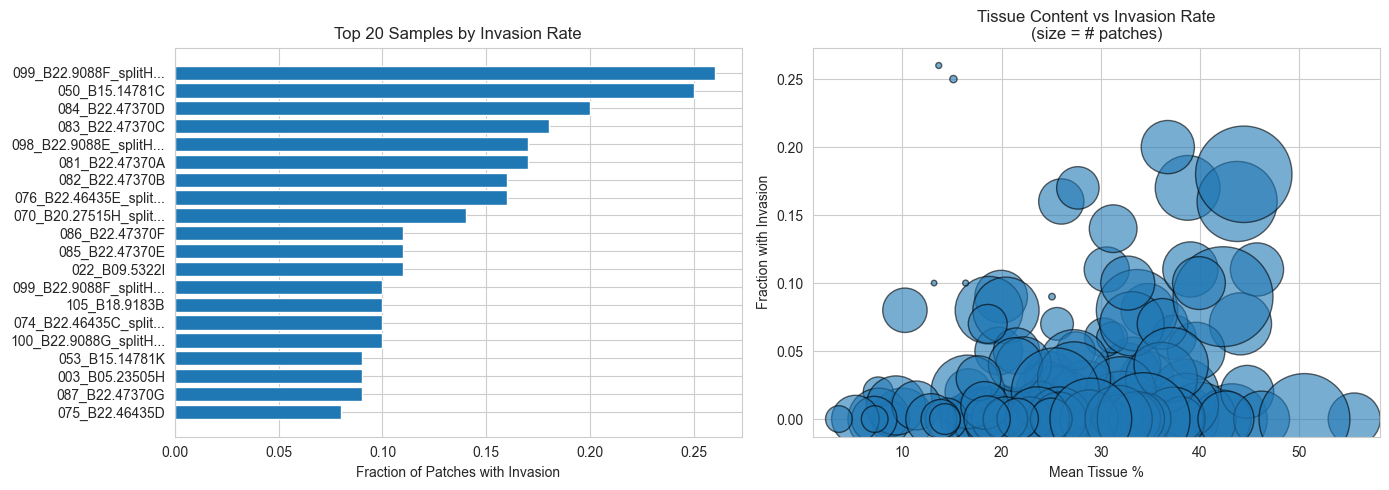

In [9]:
# Visualize sample-level invasion rates
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Invasion rate per sample
invasion_rate = sample_stats["has_invasion_mean"].sort_values(ascending=False)
axes[0].barh(range(min(20, len(invasion_rate))), invasion_rate.head(20).values)
axes[0].set_yticks(range(min(20, len(invasion_rate))))
axes[0].set_yticklabels([s[:20] + "..." if len(s) > 20 else s for s in invasion_rate.head(20).index])
axes[0].set_xlabel("Fraction of Patches with Invasion")
axes[0].set_title("Top 20 Samples by Invasion Rate")
axes[0].invert_yaxis()

# Scatter: tissue % vs invasion rate
axes[1].scatter(
    sample_stats["tissue_pct_mean"],
    sample_stats["has_invasion_mean"],
    s=sample_stats["num_patches"] / 10,
    alpha=0.6,
    edgecolors="black",
)
axes[1].set_xlabel("Mean Tissue %")
axes[1].set_ylabel("Fraction with Invasion")
axes[1].set_title("Tissue Content vs Invasion Rate\n(size = # patches)")

plt.tight_layout()
plt.savefig("sample_level_analysis.png", dpi=150, bbox_inches="tight")
plt.show()

## 6. Export Specific Subsets

In [ ]:
# Example: Save embeddings for patches with high invasion
high_invasion_mask = metadata["invasion_pct"] > 50.0
high_invasion_embeddings = embeddings[high_invasion_mask]
high_invasion_metadata = metadata[high_invasion_mask]

print(f"\nHigh invasion patches (>50%): {len(high_invasion_embeddings):,}")

# Save as numpy arrays
np.save("high_invasion_embeddings.npy", high_invasion_embeddings)
high_invasion_metadata.to_csv("high_invasion_metadata.csv", index=False)

print("Saved high invasion subset to:")
print("  - high_invasion_embeddings.npy")
print("  - high_invasion_metadata.csv")

In [ ]:
print("=" * 80)
print("Analysis complete!")
print("=" * 80)